># Project code - Social Graphs and Interactions
> ### Group 100 - s242726 (single person group)
> ### 

>## Contents
>- Introduction
>- Part 1 - Data collection and basic stats
>- Part 2 - Making the data temporal
>- Part 3 - Temporal analysis

>## Introduction
>This notebook serves as documentation for the main paper of the project. The sections in the paper correspond to the section to this note notebook, such as methodology and results. In the paper you will find links to the notebook in various sections if some methods or results from the need further explination. 

> **LLM notice!** LLMs have helped generate code and code suggestions for mulitple parts of this assigment, espeiclly when it comes to crawling code and data gathering. 

>*Research Question:* **How does temporallity affect the strucure in the canon Star Wars Character Network**

In [2]:
# Requirements

import requests
import time
import networkx as nx
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import numpy as np

## 1. Data collection of static network and inital inspection of network attributes.

### 1.1 Crawling wookiepedia for characters and outgoing links

> This was done using the fandom API and the categories "Canon articles" and "Individuals by species". 

In [ ]:
import requests
import time
import re
import networkx as nx
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup

API_URL = "https://starwars.fandom.com/api.php"
ROOT_CATEGORY = "Category:Canon articles"
INDIVIDUALS_CATEGORY = "Category:Individuals by species"

session = requests.Session()

def get_category_members(category):
    params = {
        "action": "query",
        "list": "categorymembers",
        "cmtitle": category,
        "cmlimit": "max",
        "format": "json"
    }

    pages, subcats = [], []

    while True:
        r = session.get(API_URL, params=params)
        data = r.json()
        members = data.get("query", {}).get("categorymembers", [])

        for m in members:
            if m["title"].startswith("Category:"):
                subcats.append(m["title"])
            else:
                pages.append(m["title"])

        if "continue" in data:
            params.update(data["continue"])
            time.sleep(0.02)
        else:
            break

    return pages, subcats


def collect_all_pages(root_category):
    all_pages = set()
    visited = set()
    queue = [root_category]

    while queue:
        current = queue.pop(0)
        if current in visited:
            continue
        visited.add(current)

        pages, subcats = get_category_members(current)
        all_pages.update(pages)
        queue.extend([s for s in subcats if s not in visited])

    return sorted(all_pages)


def get_page_data(title):
    """Return dict with categories, links, length, image, fullurl."""
    params = {
        "action": "query",
        "titles": title,
        "prop": "links|categories|info|pageimages",
        "piprop": "original",
        "pllimit": "max",
        "cllimit": "max",
        "inprop": "url",
        "format": "json"
    }

    for _ in range(5):
        try:
            r = session.get(API_URL, params=params, timeout=10)
            data = r.json()
            break
        except:
            time.sleep(0.1)
    else:
        return {"title": title, "categories": [], "links": [], "length": len(title), "image": "", "fullurl": ""}

    page_info = list(data.get("query", {}).get("pages", {}).values())[0]

    categories = [c["title"] for c in page_info.get("categories", [])]

    links = []
    for l in page_info.get("links", []):
        t = l["title"]
        if not any(t.startswith(prefix) for prefix in ("Category:", "File:", "Template:", "User:", "Talk:")):
            links.append(t)

    image_url = page_info.get("original", {}).get("source", "")
    fullurl = page_info.get("fullurl", "")

    length = len(title) + sum(len(cat) for cat in categories)

    return {
        "title": title,
        "categories": categories,
        "links": links,
        "length": length,
        "image": image_url,
        "fullurl": fullurl
    }


def extract_birth_death(url):
    """Scrape Wookieepedia infobox for Born/Died."""
    if not url:
        return None, None

    try:
        r = session.get(url, timeout=10)
        soup = BeautifulSoup(r.text, "html.parser")

        infobox = soup.find("aside")
        if not infobox:
            return None, None

        birth, death = None, None

        for h in infobox.find_all(["h2", "h3"]):
            label = h.get_text(strip=True).lower()
            val_tag = h.find_next("div")
            if not val_tag:
                continue

            val = val_tag.get_text(" ", strip=True)

            if "born" in label and birth is None:
                birth = val
            if "died" in label and death is None:
                death = val

        return birth, death

    except:
        return None, None


def parse_year(text):
    """Convert '57 BBY' -> -57, '4 ABY' -> 4."""
    if not text:
        return None
    m = re.search(r"(\d+)\s*(BBY|ABY)", text)
    if not m:
        return None
    num = int(m.group(1))
    return -num if m.group(2) == "BBY" else num


if __name__ == "__main__":

    print(f"Collecting canon pages from {ROOT_CATEGORY}...")
    titles = collect_all_pages(ROOT_CATEGORY)
    print(f"Canon pages: {len(titles)}\n")

    print("Collecting individuals...")
    individuals = collect_all_pages(INDIVIDUALS_CATEGORY)
    print(f"Individuals pages: {len(individuals)}\n")

    titles = sorted(set(titles).intersection(individuals))
    print(f"Canon individuals: {len(titles)}\n")

    print("Scraping page data...")
    with ThreadPoolExecutor(max_workers=20) as ex:
        results = list(tqdm(ex.map(get_page_data, titles),
                            total=len(titles), dynamic_ncols=True))

    G = nx.DiGraph()

    print("Building graph + scraping birth/death...")
    for data in tqdm(results):

        title = data["title"]
        url = data["fullurl"]

        raw_birth, raw_death = extract_birth_death(url)
        birth = parse_year(raw_birth)
        death = parse_year(raw_death)

        if birth is None:
            birth = -10000
        if death is None:
            death = 10000

        G.add_node(
            title,
            categories="; ".join(data["categories"]),
            length=data["length"],
            image=data["image"],
            url=url or "",
            birth=birth,
            death=death
        )

        for link in data["links"]:
            if link in titles:
                G.add_edge(title, link)

    if "Human" in G:
        G.remove_node("Human")

    print(f"\nGraph built: {G.number_of_nodes()} nodes | {G.number_of_edges()} edges")

    nx.write_graphml(G, "canon_network_birth_death.graphml", encoding="utf-8")
    print("Saved as canon_network_birth_death.graphml")


### 1.2 Inital test of statistics

>As seen in the code output below, this resulted in apprximatly 13000 node network. The degree distrbuions matches that of a scale free social network and the top in/out degree nodes makes logical sense with charcater like Anakina and Yoda etc. 

Nodes: 13053
Edges: 58118

Top 10 total degree: [('Anakin Skywalker', 1224), ('Darth Sidious', 995), ('Han Solo', 760), ('Leia Skywalker Organa Solo', 702), ('Obi-Wan Kenobi', 658), ('Luke Skywalker', 634), ('Kay Vess', 480), ('Chewbacca', 442), ('Jango Fett', 439), ('Dooku', 426)]
Top 10 in-degree: [('Anakin Skywalker', 1175), ('Darth Sidious', 952), ('Han Solo', 699), ('Leia Skywalker Organa Solo', 641), ('Obi-Wan Kenobi', 610), ('Luke Skywalker', 575), ('Kay Vess', 441), ('Jango Fett', 401), ('Chewbacca', 397), ('Dooku', 367)]
Top 10 out-degree: [('Hondo Ohnaka', 87), ('Mon Mothma', 87), ('Reath Silas', 83), ('Stellan Gios', 82), ('Vernestra Rwoh', 82), ('Yarael Poof', 79), ('Bail Prestor Organa', 79), ('Rex', 78), ('Cad Bane', 75), ('Saw Gerrera', 74)]


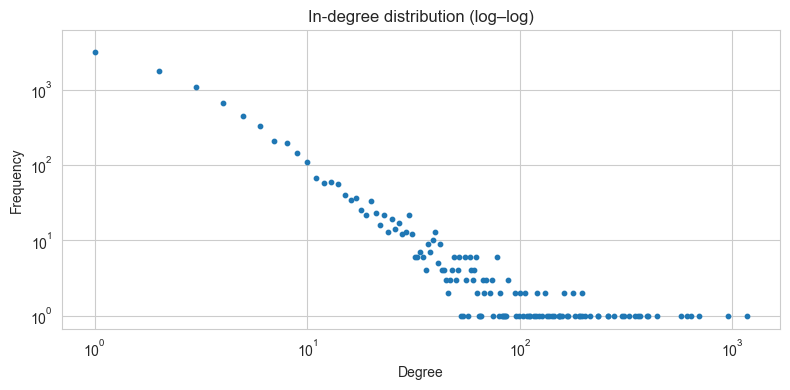

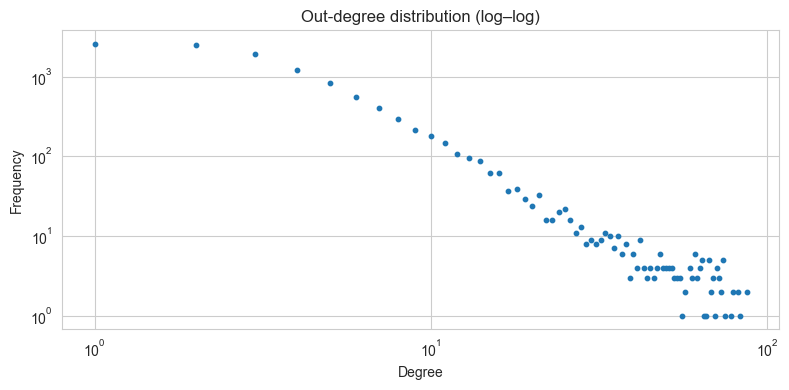


Weakly connected components: 1314
Largest WCC: 11423
Strongly connected components: 6134
Largest SCC: 5728

Running centrality...
Top betweenness: [('Yoda', 0.04535010150724738), ('Darth Sidious', 0.02918728763336671), ('Leia Skywalker Organa Solo', 0.029145533583467664), ('Chewbacca', 0.02785773408175194), ('Anakin Skywalker', 0.026262414938325856), ('Landonis Balthazar Calrissian', 0.024968256729380394), ('Ahsoka Tano', 0.022733872343057467), ('Han Solo', 0.0211663306251217), ('Jabba Desilijic Tiure', 0.021145390799471062), ("Mitth'raw'nuruodo", 0.020441009936495586)]
Top PageRank: [('Anakin Skywalker', 0.014130156602090958), ('Darth Sidious', 0.012184639657958685), ('Han Solo', 0.009106706715757328), ('Leia Skywalker Organa Solo', 0.007354293828339898), ('Kay Vess', 0.006457801130116454), ('Luke Skywalker', 0.006413926736762524), ('Chewbacca', 0.005982706968207941), ('Obi-Wan Kenobi', 0.005683087297449535), ('Ahsoka Tano', 0.005046230391798878), ('Jabba Desilijic Tiure', 0.00495044

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


path = "canon_network_with_biographies.graphml"   
G = nx.read_graphml(path)
G = nx.DiGraph(G)           

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# Degree data
in_deg = dict(G.in_degree())
out_deg = dict(G.out_degree())
tot_deg = dict(G.degree())

def top_k(d, k=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

print("\nTop 10 total degree:", top_k(tot_deg))
print("Top 10 in-degree:", top_k(in_deg))
print("Top 10 out-degree:", top_k(out_deg))

# Degree distributions 
in_vals = np.array(list(in_deg.values()))
out_vals = np.array(list(out_deg.values()))
tot_vals = np.array(list(tot_deg.values()))

# log–log plotting
def loglog_plot(vals, title):
    counts = np.bincount(vals)
    degrees = np.nonzero(counts)[0]
    freq = counts[degrees]
    plt.figure(figsize=(8, 4))
    plt.scatter(degrees, freq, s=10)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()

loglog_plot(in_vals, "In-degree distribution (log–log)")
loglog_plot(out_vals, "Out-degree distribution (log–log)")

# Connectivity
wcc_sizes = [len(c) for c in nx.weakly_connected_components(G)]
scc_sizes = [len(c) for c in nx.strongly_connected_components(G)]

print("\nWeakly connected components:", len(wcc_sizes))
print("Largest WCC:", max(wcc_sizes))

print("Strongly connected components:", len(scc_sizes))
print("Largest SCC:", max(scc_sizes))


# Basic centrality sampling
print("\nRunning centrality...")

bet = nx.betweenness_centrality(G, k=50)  
print("Top betweenness:", top_k(bet))

pr = nx.pagerank(G, alpha=0.85)
print("Top PageRank:", top_k(pr))


## 1.3 Adding character biograpies

In [ ]:
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import time

API_URL = "https://starwars.fandom.com/api.php"

def fetch_biography(title):
    """Fetch clean biography text for a character using parallel-safe requests."""
    params = {
        "action": "parse",
        "page": title,
        "prop": "text",
        "format": "json"
    }

    try:
        r = requests.get(API_URL, params=params, timeout=10)
        data = r.json()
        html = data["parse"]["text"]["*"]
    except:
        return ""

    soup = BeautifulSoup(html, "html.parser")

    # Find biography header
    bio_header = None
    for h in soup.find_all(["h2", "h3", "h4"]):
        if "biography" in h.get_text(" ", strip=True).lower():
            bio_header = h
            break

    if bio_header is None:
        return ""

    # Extract paragraphs
    bio = []
    for tag in bio_header.find_all_next():

        if tag.name == "h2" and tag is not bio_header:
            break

        if tag.name == "p":
            # skip caption paragraphs
            if tag.has_attr("class") and "caption" in tag["class"]:
                continue

            bio.append(tag.get_text(" ", strip=True))

    return "\n".join(bio).strip()



# PARALLEL SCRAPING
nodes = list(G.nodes)

def task(node):
    url = G.nodes[node]["url"]
    if not url:
        return node, ""

    title = url.split("/")[-1]

    time.sleep(0.05)

    bio = fetch_biography(title)
    return node, bio


MAX_WORKERS = 12

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futures = {ex.submit(task, node): node for node in nodes}

    for future in tqdm(as_completed(futures), total=len(nodes), ncols=100, desc="Scraping biographies (parallel)"):
        node, bio = future.result()
        G.nodes[node]["biography"] = bio


nx.write_graphml(G, "canon_network_with_biography.graphml", encoding="utf-8")
print("Saved: canon_network_with_biography.graphml")


Scraping biographies (parallel): 100%|████████████████████████| 13053/13053 [08:49<00:00, 24.65it/s]


Saved: canon_network_with_biographies.graphml


In [ ]:
import networkx as nx
import pandas as pd

# Load static network
G_static = nx.read_graphml("canon_network_with_biographies.graphml")

print("Static graph loaded.")
print("Nodes:", G_static.number_of_nodes())
print("Edges:", G_static.number_of_edges())
print("Directed:", isinstance(G_static, nx.DiGraph))

# Compute degrees
in_deg  = dict(G_static.in_degree())
out_deg = dict(G_static.out_degree())
tot_deg = {n: in_deg[n] + out_deg[n] for n in G_static.nodes()}

# Convert to pandas
df_deg = pd.DataFrame({
    "node": list(G_static.nodes()),
    "in_degree": [in_deg[n] for n in G_static.nodes()],
    "out_degree": [out_deg[n] for n in G_static.nodes()],
    "total_degree": [tot_deg[n] for n in G_static.nodes()]
})

# Sort
df_in_top  = df_deg.sort_values("in_degree", ascending=False).head(10)
df_out_top = df_deg.sort_values("out_degree", ascending=False).head(10)
df_tot_top = df_deg.sort_values("total_degree", ascending=False).head(10)

print("\nTop 10 In-Degree (Static Network)")
print(df_in_top)

print("\nTop 10 Out-Degree (Static Network)")
print(df_out_top)

print("\nTop 10 Total Degree (Static Network)")
print(df_tot_top)

# Degree stats
print("\nDegree Statistics (Static Network)")
print(df_deg[["in_degree", "out_degree", "total_degree"]].describe())


Static graph loaded.
Nodes: 13053
Edges: 58118
Directed: True

=== Top 10 In-Degree (Static Network) ===
                           node  in_degree  out_degree  total_degree
3              Anakin Skywalker       1175          49          1224
139               Darth Sidious        952          43           995
8                      Han Solo        699          61           760
61   Leia Skywalker Organa Solo        641          61           702
89               Obi-Wan Kenobi        610          48           658
9                Luke Skywalker        575          59           634
96                     Kay Vess        441          39           480
42                   Jango Fett        401          38           439
63                    Chewbacca        397          45           442
156                       Dooku        367          59           426

=== Top 10 Out-Degree (Static Network) ===
                     node  in_degree  out_degree  total_degree
234          Hondo Ohnaka    

In [ ]:
import networkx as nx

# only bios
bio_nodes = [n for n in G_static if len(G_static.nodes[n].get("biography", "")) > 0]

G_clean = G_static.subgraph(bio_nodes).copy()

# stats
print("Original nodes:", G_clean.number_of_nodes())
print("Nodes with biography:", len(G_clean))
print("Original edges:", G_clean.number_of_edges())
print("Edges in cleaned graph:", G_clean.number_of_edges())
print("Saved as canon_network_characters.graphml")


Original nodes: 3371
Nodes with biography: 3371
Original edges: 26839
Edges in cleaned graph: 26839
Saved as canon_network_characters.graphml


In [ ]:
print("Static graph loaded.")
print("Nodes:", G_clean.number_of_nodes())
print("Edges:", G_clean.number_of_edges())
print("Directed:", isinstance(G_clean, nx.DiGraph))

# degrees
in_deg  = dict(G_clean.in_degree())
out_deg = dict(G_clean.out_degree())
tot_deg = {n: in_deg[n] + out_deg[n] for n in G_clean.nodes()}

# Convert to pandas
df_deg = pd.DataFrame({
    "node": list(G_clean.nodes()),
    "in_degree": [in_deg[n] for n in G_clean.nodes()],
    "out_degree": [out_deg[n] for n in G_clean.nodes()],
    "total_degree": [tot_deg[n] for n in G_clean.nodes()]
})

# Sort
df_in_top  = df_deg.sort_values("in_degree", ascending=False).head(10)
df_out_top = df_deg.sort_values("out_degree", ascending=False).head(10)
df_tot_top = df_deg.sort_values("total_degree", ascending=False).head(10)

print("\nop 10 In-Degree (Static Network)")
print(df_in_top)

print("\nTop 10 Out-Degree (Static Network)")
print(df_out_top)

print("\nTop 10 Total Degree (Static Network)")
print(df_tot_top)

# Degree statistics
print("\nDegree Statistics (Static Network)")
print(df_deg[["in_degree", "out_degree", "total_degree"]].describe())

# Compute betweenness (normalised)
betw = nx.betweenness_centrality(G_clean, normalized=True)

df_deg["betweenness"] = df_deg["node"].map(betw)
print("\nTop 10 Betweenness Centrality")
df_betw_top = df_deg.sort_values("betweenness", ascending=False).head(10)
print(df_betw_top[["node", "betweenness", "in_degree", "out_degree", "total_degree"]])

Static graph loaded.
Nodes: 3371
Edges: 26839
Directed: True

=== Top 10 In-Degree (Static Network) ===
                            node  in_degree  out_degree  total_degree
898             Anakin Skywalker        728          38           766
1786               Darth Sidious        638          36           674
1041  Leia Skywalker Organa Solo        398          46           444
1212              Obi-Wan Kenobi        390          36           426
697                     Han Solo        388          39           427
2247              Luke Skywalker        356          40           396
2340                   Chewbacca        259          35           294
241                  Ahsoka Tano        248          51           299
407                   Jango Fett        247          31           278
2640                       Dooku        246          43           289

=== Top 10 Out-Degree (Static Network) ===
                      node  in_degree  out_degree  total_degree
283               

## 2 - Adding temporal information to the graph

> In this section we are going to scarpe and preprocess all chacaters old revisons through the oldid fandom API. This wil allow us to build a temporal network based on the timestamped revisons of characters. We can see when chacatrer emerged and their correpsoding new edges.

### 3.1 - Scraping Wookiepedia for all character page revisions

> Here I had a lot of of help from my LLM. This script loads a static Star Wars character network, keeps only characters with biography text, and queries the Wookieepedia API to retrieve each character’s full revision history. For every sampled revision, it downloads the HTML, extracts the biography section, and parses all outgoing links that point to other characters in the network. Each revision produces a snapshot containing its biography text and outgoing links, and each extracted link becomes a temporal edge with a timestamp and revision ID. All snapshots are saved as JSON files per character, all temporal edges are saved to a global file, and the original graph is updated with paths to these temporal files and written back out as a new GraphML dataset.

In [ ]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
from tqdm import tqdm
import json
import os
import time

API_URL = "https://starwars.fandom.com/api.php"

os.makedirs("data/temporal_bios2", exist_ok=True)
os.makedirs("data/temporal_edges2", exist_ok=True)


print("Loading graph...")
G = nx.read_graphml("canon_network_with_biographies.graphml")

# Keep only nodes with static biography
nodes = [
    n for n, attrs in G.nodes(data=True)
    if len(attrs.get("biography", "")) > 1
]

G = G.subgraph(nodes).copy()

print("\nAfter filtering:")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges(), "\n")


def fetch_revisions(title):
    all_revs = []
    params = {
        "action": "query",
        "prop": "revisions",
        "titles": title,
        "rvlimit": "max",
        "rvslots": "main",
        "rvprop": "ids|timestamp",
        "format": "json"
    }

    while True:
        r = requests.get(API_URL, params=params).json()
        pages = r["query"]["pages"]
        pid = next(iter(pages))
        revs = pages[pid].get("revisions", [])
        all_revs.extend(revs)

        if "continue" not in r:
            break
        params.update(r["continue"])

    return sorted(all_revs, key=lambda r: r["timestamp"])


def fetch_html(rev_id):
    params = {
        "action": "parse",
        "oldid": rev_id,
        "prop": "text",
        "format": "json"
    }
    try:
        r = requests.get(API_URL, params=params, timeout=10).json()
        return r["parse"]["text"]["*"]
    except:
        return None


def extract_bio(html):
    if not html:
        return ""
    soup = BeautifulSoup(html, "lxml")

    bio_header = None
    for h in soup.find_all(["h2", "h3", "h4"]):
        if "biography" in h.get_text(" ", strip=True).lower():
            bio_header = h
            break

    if bio_header is None:
        anchor = soup.find(id="Biography")
        if anchor:
            bio_header = anchor.parent

    if bio_header is None:
        return ""

    bio = []
    for tag in bio_header.find_all_next():
        if tag.name == "h2" and tag is not bio_header:
            break
        if tag.name == "p":
            if not (tag.has_attr("class") and "caption" in tag["class"]):
                bio.append(tag.get_text(" ", strip=True))
        if tag.name == "div" and "quote" in tag.get("class", []):
            bio.append(tag.get_text(" ", strip=True))
        if tag.name == "figure":
            t = tag.get_text(" ", strip=True)
            if t:
                bio.append(t)
        if tag.name in ["h3", "h4"] and tag is not bio_header:
            bio.append(tag.get_text(" ", strip=True))

    return "\n".join(bio).strip()


def extract_links(html, valid_nodes):
    if not html:
        return []

    soup = BeautifulSoup(html, "lxml")
    links = []

    for a in soup.find_all("a", href=True):
        href = a["href"]

        if not href.startswith("/wiki/"):
            continue

        title = href.split("/wiki/")[-1]

        
        if any(title.startswith(p) for p in ["Category:", "File:", "Template:", "User:", "Talk:"]):
            continue

       
        if title in valid_nodes:
            links.append(title)

    return links

print("=== BEGIN TEMPORAL SCRAPING ===\n")

valid_titles = {G.nodes[n]["url"].split("/wiki/")[-1]: n
                for n in G.nodes()
                if "url" in G.nodes[n] and "/wiki/" in G.nodes[n]["url"]}

temporal_edge_list = []  

for node in tqdm(G.nodes(), desc="Characters processed"):
    url = G.nodes[node].get("url", "")
    if not url or "/wiki/" not in url:
        G.nodes[node]["bio_json"] = ""
        continue

    title = url.split("/wiki/")[-1]

    
    revs = fetch_revisions(title)
    if len(revs) == 0:
        G.nodes[node]["bio_json"] = ""
        continue

    sampled = revs[::100]
    snapshots = []

    for rev in sampled:
        rid = rev["revid"]
        ts = rev["timestamp"]

        html = fetch_html(rid)
        bio = extract_bio(html)
        links = extract_links(html, valid_titles)

        
        for tgt_title in links:
            tgt_node = valid_titles[tgt_title]
            temporal_edge_list.append({
                "source": node,
                "target": tgt_node,
                "timestamp": ts,
                "rev_id": rid
            })

        snapshots.append({
            "rev_id": rid,
            "timestamp": ts,
            "bio": bio,
            "links": links
        })

        time.sleep(0.2)  

  
    json_path = f"data/temporal_bios2/{title}.json"
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(snapshots, f, indent=2, ensure_ascii=False)

    G.nodes[node]["bio_json"] = json_path


edge_file = "data/temporal_edges2/temporal_edges.json"
with open(edge_file, "w", encoding="utf-8") as f:
    json.dump(temporal_edge_list, f, indent=2, ensure_ascii=False)


output_file = "canon_network_with_temporal_bio_paths2.graphml"
nx.write_graphml(G, output_file)

print("\n=== DONE ===")
print(f"Graph saved to: {output_file}")
print(f"Temporal biographies in: data/temporal_bios/")
print(f"Temporal edges in: {edge_file}")


Loading graph...

After filtering:
Nodes: 3371
Edges: 26839 

=== BEGIN TEMPORAL SCRAPING ===



Characters processed: 100%|██████████| 3371/3371 [3:15:35<00:00,  3.48s/it]     



=== DONE ===
Graph saved to: canon_network_with_temporal_bio_paths2.graphml
Temporal biographies in: data/temporal_bios2/
Temporal edges in: data/temporal_edges2/temporal_edges.json


### 2.2 - Building snapshopts from the collected revisions

>This code below loads every characters revision history, converts timestamps, and sorts all snapshots chronologically. It then gathers all unique timestamps between 2014 and 2025 and reconstructs the directed character network at each timestamp by taking, for every character, the most recent revision available up to that point and extracting its outgoing links. This produces a full temporal sequence of network snapshots. Finally, the code downsamples the timeline by selecting roughly 60 evenly spaced timestamps to create a manageable set of snapshots for analysis.


In [37]:
import os
import json
import pandas as pd

BIO_FOLDER = "data/temporal_bios2"

character_history = {}

for file in os.listdir(BIO_FOLDER):
    if not file.endswith(".json"):
        continue

    path = os.path.join(BIO_FOLDER, file)
    with open(path, "r", encoding="utf-8") as f:
        snaps = json.load(f)

    for s in snaps:
        s["timestamp"] = pd.to_datetime(s["timestamp"], utc=True)

    title = file.replace(".json", "")
    character_history[title] = sorted(snaps, key=lambda x: x["timestamp"])


# Collect from 2014-2025
all_timestamps = sorted({
    snap["timestamp"]
    for snaps in character_history.values()
    for snap in snaps
    if snap["timestamp"].year >= 2014 and snap["timestamp"].year <= 2025
})

# make snapshots

snapshot_edges = {}

for ts in all_timestamps:
    edges = []
    for char, snaps in character_history.items():
        valid = [s for s in snaps if s["timestamp"] <= ts]
        if not valid:
            continue
        latest = valid[-1]
        for tgt in latest.get("links", []):
            edges.append((char, tgt))
    snapshot_edges[ts] = edges


# Bin into qual equal progression
BIN_COUNT = 60
step = max(1, len(all_timestamps) // BIN_COUNT)
binned_ts = all_timestamps[::step]

print("Binned snapshots:", len(binned_ts))


Binned snapshots: 61


## 3 - Temporal Analysis

>In this section we cover 3 parts of analysis. First, we look at some basic network science statstics over time, such as nodes and degrees and centrality to see how the network behaves over time. Then in section 3.2 we look at lovian commutnites over time. Lastly we use the biographies of each chacater to look the the different communites over time in terms of most reoccuring words so we can get an indidcation of what those comunites conists of. 

### 3.1 - Basic temporal analysis

> This first block builds the actual temporal network snapshots. It takes the binned timestamps, selects every 10th snapshot to reduce computation, and for each selected timestamp builds a directed graph containing all edges whose source–target links existed at or before that time. Each timestamp becomes its own NetworkX DiGraph, stored in snapshot_graphs. The code then prints the node and edge counts for each constructed snapshot.

In [ ]:
import networkx as nx

# Choose every 10th snapshot to reduce compute time
indices = list(range(0, len(binned_ts), 10))
selected_ts = [binned_ts[i] for i in indices]

snapshot_graphs = {}

print(f"Total snapshots available: {len(binned_ts)}")
print(f"Selected: {len(selected_ts)} (every 10th)\n")

for ts in selected_ts:
    edges = snapshot_edges[ts]
    G_snap = nx.DiGraph()
    G_snap.add_edges_from(edges)
    snapshot_graphs[ts] = G_snap

# print summary
for ts in selected_ts:
    Gs = snapshot_graphs[ts]
    print(f"{ts}  |  Nodes: {Gs.number_of_nodes():4d}   Edges: {Gs.number_of_edges():4d}")


Building graph objects...
Total snapshots available: 61
Selected: 7 (every 10th)

2014-01-12 08:51:04+00:00  |  Nodes:   39   Edges:   35
2016-04-10 17:39:27+00:00  |  Nodes:  853   Edges: 2790
2018-05-03 06:46:25+00:00  |  Nodes: 1362   Edges: 6826
2020-05-20 13:04:20+00:00  |  Nodes: 1856   Edges: 10006
2022-03-09 06:37:08+00:00  |  Nodes: 2234   Edges: 13456
2023-11-05 05:00:36+00:00  |  Nodes: 2626   Edges: 16748
2025-10-20 22:42:44+00:00  |  Nodes: 3041   Edges: 20647


>This block computes structural metrics for every temporal snapshot graph and stores both node-level and snapshot-level statistics. For each timestamped graph, it calculates degree, degree centrality, betweenness, and eigenvector centrality for all nodes. These per-node metrics are saved into a dataframe (results[ts]). Then it builds a summary row describing the whole snapshot: number of nodes and edges, average and maximum degree, average and maximum betweenness, and average and maximum eigenvector centrality. All snapshots are then combined into a chronological summary table (evolution_df) that tracks how network structure changes over time

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np

results = {}        # full node-level tables per timestamp
evolution = []      # summary table entries


for ts, G_snap in snapshot_graphs.items():
    if G_snap.number_of_nodes() == 0:
        continue

    # Degree measures
    deg = dict(G_snap.degree())
    deg_cent = nx.degree_centrality(G_snap)

    # Core centralities
    btw = nx.betweenness_centrality(G_snap, normalized=True)

    # Node-level dataframe (saved but not printed)
    df = pd.DataFrame({
        "degree": pd.Series(deg),
        "degree_centrality": pd.Series(deg_cent),
        "betweenness": pd.Series(btw),
        "eigenvector": pd.Series(eig)
    })
    results[ts] = df

    # summary stats
    evolution.append({
        "timestamp": ts,
        "nodes": G_snap.number_of_nodes(),
        "edges": G_snap.number_of_edges(),
        "avg_degree": df["degree"].mean(),
        "max_degree": df["degree"].max(),
        "avg_betweenness": df["betweenness"].mean(),
        "max_betweenness": df["betweenness"].max(),
    })

# Convert to clean pandas
evolution_df = pd.DataFrame(evolution).sort_values("timestamp")
evolution_df.reset_index(drop=True, inplace=True)

print("Snapshot Summary (Evolution over Time)")
display(evolution_df)


=== Snapshot Summary (Evolution over Time) ===


,timestamp,nodes,edges,avg_degree,max_degree,avg_betweenness,max_betweenness,avg_eigenvector,max_eigenvector
0,2014-01-12 08:51:04+00:00,39,35,1.794872,4,0.000000,0.000000,0.131080,0.365148
1,2016-04-10 17:39:27+00:00,853,2790,6.541618,248,0.000413,0.061814,0.015687,0.298230
2,2018-05-03 06:46:25+00:00,1362,6826,10.023495,401,0.000515,0.085855,0.011189,0.292249
3,2020-05-20 13:04:20+00:00,1856,10006,10.782328,561,0.000503,0.107147,0.008838,0.289796
4,2022-03-09 06:37:08+00:00,2234,13456,12.046553,668,0.000522,0.115910,0.007919,0.290768
5,2023-11-05 05:00:36+00:00,2626,16748,12.755522,527,0.000488,0.079541,0.006900,0.287223
6,2025-10-20 22:42:44+00:00,3041,20647,13.579086,614,0.000482,0.092110,0.006234,0.289800


>As seen in the results, the network grows from 39 to over 3,000 characters, with edges increasing even faster. This produces a steady rise in average degree, showing that characters become more interconnected over time. Maximum degree and maximum betweenness also increase, indicating the emergence of highly central hub characters. Eigenvector centrality becomes more concentrated, reflecting that a small subset of characters dominate the network’s structural influence as the canon expands

>This plotting code below compares the degree distributions of an early and a late snapshot using log–log scatter plots. Both in-degree and out-degree follow heavy-tailed shapes, meaning most characters have few links while a small number act as hubs. In the later snapshot the tail extends further, showing more high-degree characters and a broader spread of connectivity. This confirms that as the canon expands, the network becomes more heterogeneous and hub-dominated

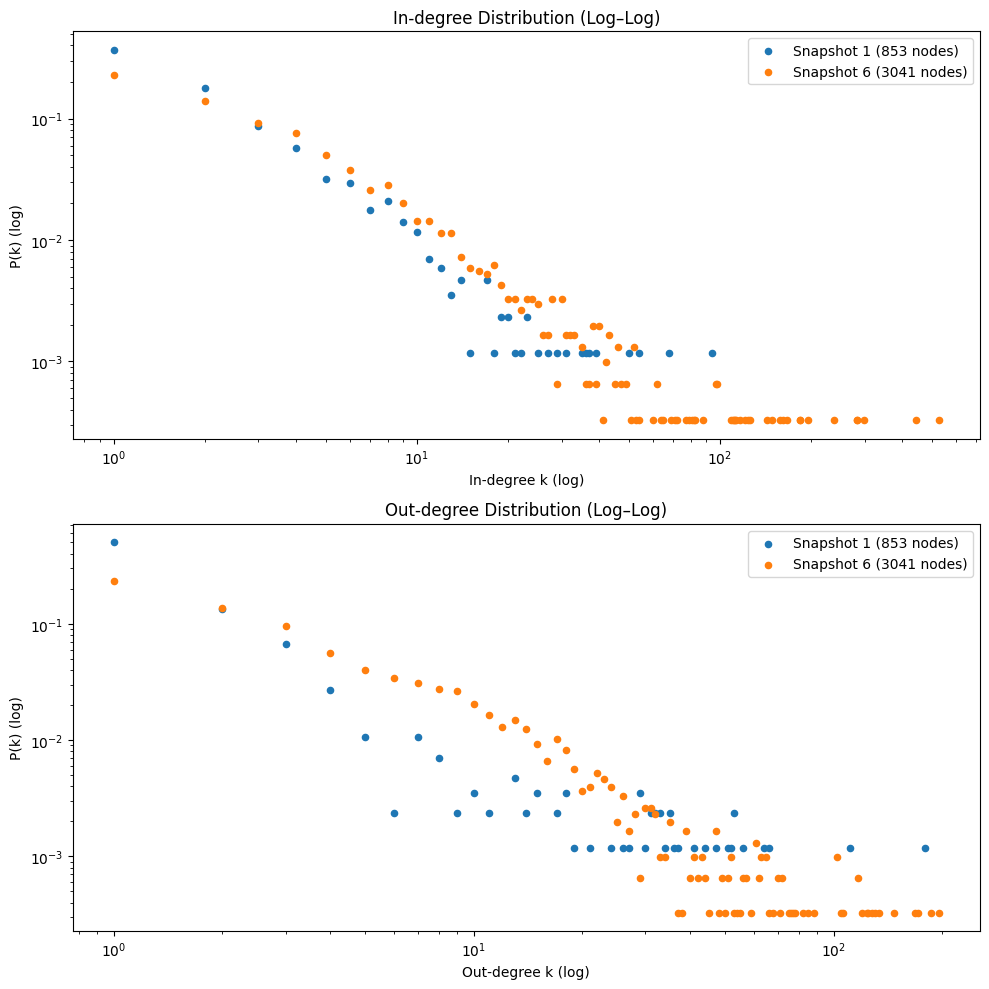

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# choose two snapshots 
i1 = 1                        
i2 = len(selected_ts) - 1     

ts1 = selected_ts[i1]
ts2 = selected_ts[i2]

G1 = snapshot_graphs[ts1]
G2 = snapshot_graphs[ts2]

def degree_hist(degrees):
    vals, counts = np.unique(degrees, return_counts=True)
    freq = counts / counts.sum()
    return vals, freq

# get degrees
in1  = [d for _, d in G1.in_degree()]
in2  = [d for _, d in G2.in_degree()]
out1 = [d for _, d in G1.out_degree()]
out2 = [d for _, d in G2.out_degree()]

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# in-degree distribution
x1, y1 = degree_hist(in1)
x2, y2 = degree_hist(in2)

axes[0].scatter(x1, y1, s=20, label=f"Snapshot {i1} ({G1.number_of_nodes()} nodes)")
axes[0].scatter(x2, y2, s=20, label=f"Snapshot {i2} ({G2.number_of_nodes()} nodes)")

axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("In-degree k (log)")
axes[0].set_ylabel("P(k) (log)")
axes[0].set_title("In-degree Distribution (Log–Log)")
axes[0].legend()

# out-degree distribution
x1, y1 = degree_hist(out1)
x2, y2 = degree_hist(out2)

axes[1].scatter(x1, y1, s=20, label=f"Snapshot {i1} ({G1.number_of_nodes()} nodes)")
axes[1].scatter(x2, y2, s=20, label=f"Snapshot {i2} ({G2.number_of_nodes()} nodes)")

axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("Out-degree k (log)")
axes[1].set_ylabel("P(k) (log)")
axes[1].set_title("Out-degree Distribution (Log–Log)")
axes[1].legend()

plt.tight_layout()
plt.show()


### 3.2 - Temporal community evolution

>Before looking at how communities change over time, we first need community labels for each snapshot of the network. The code below runs the Louvain algorithm independently on every timestamp. Louvain is fast, works well on large graphs, and gives us a rough idea of how the network is clustered at each point in time.
>
>We convert each snapshot to an undirected graph because Louvain works on undirected networks. Then we store the partition as a simple {node: community_id} dictionary. At this stage, community IDs are arbitrary and only make sense within each snapshot.

In [ ]:
import community as community_louvain

raw_communities = {}  

for ts, G_snap in snapshot_graphs.items():
    if G_snap.number_of_nodes() == 0:
        continue
    
    # convert to undirected for Louvain 
    G_u = G_snap.to_undirected()

    # b uild partition dict: {node: community_id}
    part = community_louvain.best_partition(G_u, random_state=42)
    raw_communities[ts] = part

    print(f"{ts}: detected {len(set(part.values()))} communities")


2014-01-12 08:51:04+00:00: detected 31 communities
2016-04-10 17:39:27+00:00: detected 188 communities
2018-05-03 06:46:25+00:00: detected 195 communities
2020-05-20 13:04:20+00:00: detected 176 communities
2022-03-09 06:37:08+00:00: detected 137 communities
2023-11-05 05:00:36+00:00: detected 119 communities
2025-10-20 22:42:44+00:00: detected 105 communities


>Louvain gives us community labels for each snapshot, but the labels are random every time it runs.
Community “0” in 2016 is not the same as community “0” in 2018.
So if we want to talk about how a community evolves, we need to give each real community a stable ID that carries across snapshots.
>
>This block does exactly that. The idea is to:
>
>1. Look at the communities in the current snapshot.
>
>2. Compare each one with the communities from the previous snapshot.
>
>3. If a new cluster overlaps strongly with an old one (measured with Jaccard similarity), treat them as the same continuing community.
>
>4. If not, assign a fresh community ID.
>
>This lets us track which clusters grow, shrink, or disappear.

In [ ]:
from collections import defaultdict

aligned_communities = {}
next_global_id = 0
timestamps = sorted(raw_communities.keys())

prev_clusters = {}

# threshold for deciding continuity
JACCARD_THRESHOLD = 0.2

for ts in timestamps:
    raw = raw_communities[ts] 
    
    # build current clusters
    curr_clusters = defaultdict(set)
    for n, cid in raw.items():
        curr_clusters[cid].add(n)

    stable = {}
    curr_to_stable = {}  

    # first snapshot: assign new global ids
    if not prev_clusters:
        for rid, nodes in curr_clusters.items():
            curr_to_stable[rid] = next_global_id
            next_global_id += 1
        # build mapping to nodes
        for node, rid in raw.items():
            stable[node] = curr_to_stable[rid]
        aligned_communities[ts] = stable
        # update prev clusters
        prev_clusters = defaultdict(set)
        for node, sid in stable.items():
            prev_clusters[sid].add(node)
        continue

    # match old and new with jaccard 
    for rid, new_nodes in curr_clusters.items():
        best_sid = None
        best_sim = 0.0

        for sid, old_nodes in prev_clusters.items():
            inter = len(new_nodes & old_nodes)
            union = len(new_nodes | old_nodes)
            sim = inter / union if union > 0 else 0

            if sim > best_sim:
                best_sim = sim
                best_sid = sid

        # if similarity strong enough assign old id
        if best_sim >= JACCARD_THRESHOLD:
            curr_to_stable[rid] = best_sid
        else:
            # new community
            curr_to_stable[rid] = next_global_id
            next_global_id += 1

    # assign stable ids to nodes
    for node, rid in raw.items():
        stable[node] = curr_to_stable[rid]

    aligned_communities[ts] = stable

    # rebuild prev clusters
    prev_clusters = defaultdict(set)
    for node, sid in stable.items():
        prev_clusters[sid].add(node)

print("Improved community alignment complete.")


Improved community alignment complete.


>Once each snapshot has stable community IDs, we need a format that is easy to analyse and plot. The code below converts the aligned community assignments into a long dataframe where each row represents one character at one timestamp.

In [ ]:
rows = []

for ts, mapping in aligned_communities.items():
    for node, comm in mapping.items():
        rows.append({
            "timestamp": ts,
            "node": node,
            "community": comm
        })

community_evolution_df = pd.DataFrame(rows).sort_values(["timestamp", "community", "node"])


>Now that all communities have stable IDs, we can compute simple summary statistics for each timestamp. The goal here is not advanced modelling but a straightforward description of how the network and its communities grow over time.

In [ ]:
from community import community_louvain

summary_rows = []

for ts, mapping in aligned_communities.items():
    # mapping {node: community}
    comm_sizes = pd.Series(mapping).value_counts()

    # compute modularity from original Louvain
    G_u = snapshot_graphs[ts].to_undirected()
    part = raw_communities[ts]                  
    mod = community_louvain.modularity(part, G_u)

    summary_rows.append({
        "timestamp": ts,
        "num_nodes": len(mapping),
        "num_communities": comm_sizes.shape[0],
        "mean_size": comm_sizes.mean(),
        "median_size": comm_sizes.median(),
        "largest_size": comm_sizes.max(),
        "modularity": mod
    })

community_summary_df = pd.DataFrame(summary_rows).sort_values("timestamp")
display(community_summary_df)


,timestamp,num_nodes,num_communities,mean_size,median_size,largest_size,modularity
0,2014-01-12 08:51:04+00:00,39,31,1.258065,1.0,5,0.960000
1,2016-04-10 17:39:27+00:00,853,188,4.537234,1.0,132,0.610114
2,2018-05-03 06:46:25+00:00,1362,195,6.984615,1.0,255,0.573554
3,2020-05-20 13:04:20+00:00,1856,176,10.545455,1.0,290,0.582006
4,2022-03-09 06:37:08+00:00,2234,135,16.548148,1.0,437,0.570451
5,2023-11-05 05:00:36+00:00,2626,118,22.254237,1.0,455,0.571231
6,2025-10-20 22:42:44+00:00,3041,103,29.524272,1.0,777,0.585025


>The table shows clear consolidation over time. The number of nodes increases sharply, while the number of communities drops from 188 to 103. Average community size grows steadily, and the largest community expands from 132 to 777 members. The median size stays at 1, reflecting many small groups alongside a few large ones. Modularity remains stable around 0.57–0.61, meaning the network stays clustered even as it grows. The 2014 value is inflated due to the very small graph.

>This block breaks down the community size distribution at each timestamp. Instead of just looking at averages, it counts how many communities fall into simple size brackets (size 1, size ≥2, size ≥5, size ≥10). This gives a clearer picture of how many very small groups exist compared with the larger, more meaningful ones.

In [15]:
real_rows = []

for ts, mapping in aligned_communities.items():
    comm_sizes = pd.Series(mapping).value_counts()

    real_rows.append({
        "timestamp": ts,
        "num_comm_total": len(comm_sizes),
        "comm_size_1": (comm_sizes == 1).sum(),
        "comm_ge_2": (comm_sizes >= 2).sum(),
        "comm_ge_5": (comm_sizes >= 5).sum(),
        "comm_ge_10": (comm_sizes >= 10).sum(),
        "largest": comm_sizes.max()
    })

real_df = pd.DataFrame(real_rows).sort_values("timestamp")
display(real_df)

,timestamp,num_comm_total,comm_size_1,comm_ge_2,comm_ge_5,comm_ge_10,largest
0,2014-01-12 08:51:04+00:00,31,26,5,1,0,5
1,2016-04-10 17:39:27+00:00,188,165,23,10,8,132
2,2018-05-03 06:46:25+00:00,195,161,34,11,11,255
3,2020-05-20 13:04:20+00:00,176,137,39,18,16,290
4,2022-03-09 06:37:08+00:00,135,104,31,14,13,437
5,2023-11-05 05:00:36+00:00,118,79,39,18,15,455
6,2025-10-20 22:42:44+00:00,103,64,39,16,14,777


>The distribution confirms the consolidation trend. The total number of communities decreases over time, and the number of size-1 communities drops sharply from 165 to 64. Meanwhile, the number of medium or large communities (≥5 or ≥10 members) stays relatively stable. This means most of the reduction comes from tiny groups disappearing, while the larger communities continue to grow and absorb new characters. The largest community increases steadily, reaching 777 members by 2025.

### Adding TF-IDF to explain communites

>Now we are going to see if we are able to determine the idea of each major cluster in the end of our time series. To get a rough idea of what the largest 2025 communities represent, we build a small text corpus based on character biographies. We only keep communities with at least ten members, since smaller ones tend to be noisy and do not give meaningful text signals. 
>
> Because the revision history is messy and inconsistent, we use only the final version of each biography rather than trying to track textual changes over time. We then combine all biographies within the same community into a single document. These documents form the input for the TF–IDF step, where we look for terms that distinguish one community’s text from another.

In [ ]:
import json
import os
import pandas as pd

FINAL_TS = max(aligned_communities.keys())  
final_mapping = aligned_communities[FINAL_TS]  

# minimum size to consider a real community here
MIN_SIZE = 10

# count 
comm_sizes = pd.Series(final_mapping).value_counts()

# keep large communities
valid_comms = set(comm_sizes[comm_sizes >= MIN_SIZE].index)

print(f"Final snapshot: {FINAL_TS}")
print(f"Communities (size >= {MIN_SIZE}): {len(valid_comms)}")

# Build text corpus
community_texts = {cid: [] for cid in valid_comms}

BIO_FOLDER = "data/temporal_bios2"

for node, cid in final_mapping.items():
    if cid not in valid_comms:
        continue

    # use url title to match
    title = node.replace(" ", "_") 
    path = os.path.join(BIO_FOLDER, f"{title}.json")

    if not os.path.exists(path):
        continue

    # load biography snapshots
    with open(path, "r", encoding="utf-8") as f:
        snaps = json.load(f)

    # use the latest biography available
    if len(snaps) == 0:
        continue

    latest_bio = snaps[-1].get("bio", "")
    if latest_bio:
        community_texts[cid].append(latest_bio)

# combine texts 
community_docs = {
    cid: "\n".join(texts)
    for cid, texts in community_texts.items()
}

print("Example community IDs:", list(community_docs.keys())[:5])
print("Ready for TF–IDF.")


Final snapshot: 2025-10-20 22:42:44+00:00
Communities (size >= 10): 14
Example community IDs: [35, 38, 39, 328, 203]
Ready for TF–IDF.


>We Can now a aplly a standard TF–IDF vectoriser with English stopwords removed and a minimum document frequency to filter out single terms. For each community, we then extract the top 15 weighted terms. As expected, many of these turn out to be character names, locations, or recurring plot terms, which reflects the style of Wookieepedia biography text. Even so, the keywords help identify broad story clusters such as the Rebels era, the Mandalorian characters, game-era groups like Cal Kestis, and High Republic material.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Prepare
community_ids = list(community_docs.keys())
documents = [community_docs[cid] for cid in community_ids]

# TF–IDF vectoriser
vectoriser = TfidfVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=5,          
    ngram_range=(1,2)  
)

tfidf_matrix = vectoriser.fit_transform(documents)
feature_names = vectoriser.get_feature_names_out()

# top words
top_k = 15
community_keywords = {}

for idx, cid in enumerate(community_ids):
    row = tfidf_matrix[idx].toarray().flatten()
    top_indices = row.argsort()[::-1][:top_k]
    keywords = [feature_names[i] for i in top_indices]
    community_keywords[cid] = keywords

# results table
keywords_table = pd.DataFrame({
    "community_id": community_ids,
    "keywords": [", ".join(community_keywords[cid]) for cid in community_ids]
}).sort_values("community_id")

display(keywords_table)


,community_id,keywords
0,35,"jedi, kenobi, tano, clone, omega, rex, skywalker, dooku, republic, maul, amidala, grievous, battle, clones, ventress"
1,38,"ezra, sabine, kanan, hera, imperial, rebels, thrawn, chopper, wren, lothal, bridger, kallus, jedi, ghost, jarrus"
2,39,"kestis, junda, jedi, cal, crew, sister, cal kestis, second, lightsaber, cere, imperial, holocron, dathomir, cere junda, master"
4,203,"solo, skywalker, organa, ren, leia, rey, imperial, resistance, han, chewbacca, battle, jedi, republic, sloane, hux"
5,207,"andor, imperial, gerrera, jyn, rebel, galen, erso, saw, cassian, mothma, yularen, star, rook, partisans, death star"
11,215,"twilight, company, imperial, alliance, brand, rebel, soldiers, echo base, sullust, echo, herald, squad, command, src, sergeant"
12,281,"djarin, aphra, fett, grogu, bounty, mandalorian, boba, gideon, starros, din, dune, imperial, solo, din djarin, vader"
6,304,"jedi, nihil, master, yoda, ro, starlight, padawan, republic, beacon, jedi master, lightsaber, council, temple, stranger, great"
10,309,"chiss, thrawn, sunrise, navigator, species, hammer, refugees, enlightened, frigate, commander, senior, regions, unknown regions, ascendancy, civil"
13,317,"tarkin, vader, sidious, jedi, imperial, emperor, star, skywalker, palpatine, sith, darth, death star, republic, battle, lee char"
